In [8]:
import torch
import numpy as np
from tqdm import tqdm
from scipy.stats.distributions import chi2
from scipy.stats import pearsonr
import pickle

import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
import matplotlib.animation as animation
import sys, os

path = os.path.dirname(os.getcwd())
sys.path.append(path)

from utils.plots import *
from utils.funcs import *
from utils.visualize_network import *
from utils.visualize_hidden_network import *

from boltzmann_machines.RTRBM_ import RTRBM as RTRBM_
from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RTRBM_no_bias import RTRBM_nobias
from boltzmann_machines.RBM import RBM

from data.load_data import *
from data.mock_data import *
from data.reshape_data import *

How many batches are nessesary to reproduce the weights with a pearson correlation of > 0.95


Minimum connectivity is: tensor(0.3333)
tensor(0.5190)


C:\Users\sebas\AppData\Local\Temp/ipykernel_24328/2556344435.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float, device='cpu')


<AxesSubplot:>

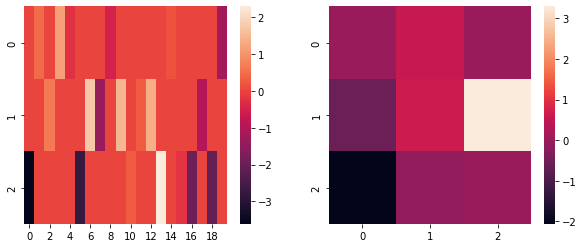

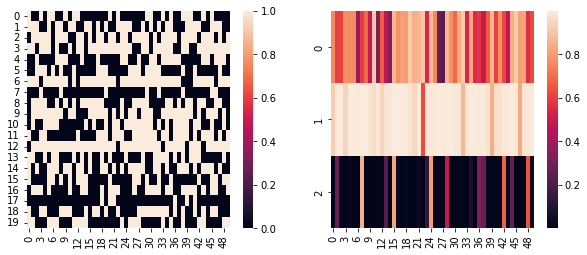

In [40]:
def gen_weights(N_H, N_V, nabla=2, connectivity=0):
    ## initialize parameters
    sparcity = 1 - connectivity

    sp = 1 - 1/N_H
    # initialze fully connected random weight matrix
    W = nabla * torch.randn((N_H, N_V), dtype=torch.float)

    # Make the weight matrix sparse such that only 1 visible is randomly connected to 1 hidden
    for i, idx in enumerate(torch.randperm(N_V)):
        if torch.sum(W[:, idx]==0)/N_H<sp:
            W[:, idx][ np.random.permutation(N_H)[:int(np.ceil(sp * N_H))]] = 0

    # compute the number of zeros we need to have in the weight matrix to obtain the predefined connectivity
    sp = torch.sum(W==0)/W.numel()
    conn = 1 - sp
    n_zeros = int(torch.sum(W==0) - sparcity * W.numel())
    if n_zeros>0:
        # randomly add values to the weight matrix in order to obtain the predefined connectivity
        idx = torch.where(W.ravel() == 0)[0]
        idx = idx[torch.randperm(idx.shape[0])[:n_zeros]]
        W.ravel()[idx] = nabla * torch.randn(n_zeros, dtype=torch.float)
    else:
        print('Minimum connectivity is: '+str(conn))
    # sp = torch.sum(W==0)/W.numel()
    # conn = 1 - sp

    return W
N_H, N_V = 3, 20
W = gen_weights(N_H=N_H, N_V=N_V, nabla=2, connectivity=0)
U = gen_weights(N_H=N_H, N_V=N_H, nabla=2, connectivity=0.7)
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(W, ax=ax[0])
sns.heatmap(U, ax=ax[1])

In [ ]:
# Initialize rtrbm
T = 50

rtrbm_init= RTRBM(torch.zeros(N_V, T), N_H=N_H, device='cpu')
rtrbm_init.W = W
rtrbm_init.U = U
rtrbm_init.b_H = torch.zeros(1, N_H, dtype=torch.float)
rtrbm_init.b_V = torch.zeros(1, N_V, dtype=torch.float)
rtrbm_init.b_init = torch.zeros(1, N_H, dtype=torch.float)

100%|██████████| 500/500 [03:21<00:00,  2.48it/s]
C:\Users\sebas\AppData\Local\Temp/ipykernel_24328/379055240.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float, device='cpu')


tensor(0.5240)


<AxesSubplot:>

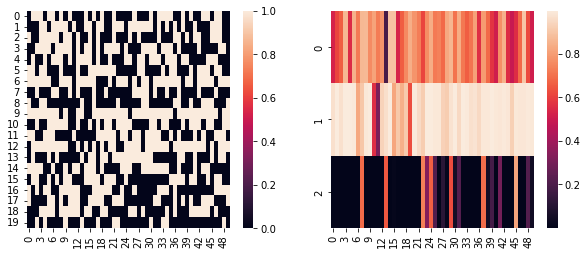

In [42]:
n_batches = 500
data = torch.zeros(N_V, T, n_batches)
rt = torch.zeros(N_H, T, n_batches)
for batch in tqdm(range(n_batches)):
    v_start = (torch.rand(N_V) > 0.3)*1.0
    data[:, :, batch], rt[:, :, batch] = rtrbm_init.sample(v_start.type(torch.float), chain=T, pre_gibbs_k=100, gibbs_k=100, mode=1, disable_tqdm=True)
data = torch.tensor(data, dtype=torch.float, device='cpu')
print(torch.mean(data))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(data[:, :, 0].cpu(), ax=ax[0])
sns.heatmap(rt[:, :, 0].cpu(), ax=ax[1])

100%|██████████| 1000/1000 [22:53<00:00,  1.37s/it]


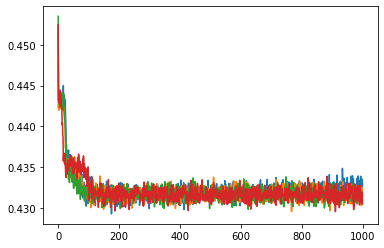

In [47]:
for sp in [1e-7, 1e-8, 1e-9, 1e-10]:#[0, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]:
    rtrbm = RTRBM_nobias(data, N_H=N_H, device='cpu')
    rtrbm.learn(n_epochs=1000, batchsize=10, CDk=10, lr=1e-3, lr_end=1e-5, start_decay=100, \
                mom=0.9, wc=0.0002, sp=sp, x=2)
    plt.plot(rtrbm.errors)
    torch.save(rtrbm, open(r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\Reproduce_rtrbm\sparcity\rtrbm_sp_'+str(sp), 'wb'))

In [ ]:
torch.save(rtrbm, open(r'C:\Users\sebas\OneDrive\Intern\rtrbm_master\results\Reproduce_rtrbm\sparcity', 'wb'))

In [19]:
W_original = rtrbm_init.W.detach().clone()
W_train = rtrbm.W.detach().clone()
U_original = rtrbm_init.U.detach().clone()
U_train = rtrbm.U.detach().clone()

corr = np.zeros((N_H, N_H))
shuffle_idx = np.zeros((N_H))
for i in range(N_H):
    for j in range(N_H):
        corr[i, j] = np.correlate(W_original[i,:], W_train[j,:])
    shuffle_idx[i] = np.argmax(corr[i,:])

W_train = W_train[shuffle_idx, :]
U_train = U_train[shuffle_idx, :]
U_train = U_train[:, shuffle_idx]

_, _, r_W, _, _ = linregress(W_original.ravel(), W_train.ravel())
_, _, r_U, _, _ = linregress(U_original.ravel(), U_train.ravel())

fig, ax = plt.subplots(2, 1, figsize=(8,8))
ax[0].scatter(W_original.ravel(), W_train.ravel())
ax[0].set_xlabel('Original')
ax[0].set_ylabel('Trained')
ax[0].set_title('r-value:'+str(r_W))
ax[1].scatter(U_original.ravel(), U_train.ravel())
ax[1].set_xlabel('Original')
ax[1].set_ylabel('Trained')
ax[1].set_title('r-value:'+str(r_U))

0.6404174352093323 -0.2617209677780094
